In [1]:
%load_ext autoreload
%autoreload 2

# The Metastatic Tissue Classification problem -- About the dataset

---

## 1. Introduction

This notebook provides a brief introduction to the Patch Camelyon (PCam) dataset. It presents summary statistics, displays sample images, and demonstrates how to use the `PCamDataset` and `PCamDataModule` classes for loading and managing the data.

The `PCamDataset` and `PCamDataModule` classes are defined and implemented in the `pcam_dataset.py` and `MO810_API.py` files.



---

## 2. The Patch Camelyon dataset

The Patch Camelyon dataset contains over 300k images of histopathologic scans of lymph node sections. It's a challenging image classification dataset benchmark, with images (96 x 96px) annoted with a binary label indicating presence of metastatic tissue. PCam provides a new benchmark for machine learning models: bigger than CIFAR10, smaller than imagenet, trainable on a single GPU. 

This dataset, derived from the original Camelyon-16, was presented in "[Rotation Equivariant CNNs for Digital Pathology](http://arxiv.org/abs/1806.03962)", and can be accessed through multiple sources.

* [GitHub](https://github.com/basveeling/pcam)
* [Grand Challenge](https://patchcamelyon.grand-challenge.org)
* [Kaggle](https://www.kaggle.com/datasets/andrewmvd/metastatic-tissue-classification-patchcamelyon)s

---
## 3. Setting up the dataset

We will use a PyTorch Dataset class that was created to automatically download the dataset.

In [ ]:
from dataset_pcam import PCamDataset

dataset = PCamDataset(data_dir="./data")
print(f"Datset size: {len(dataset)} samples")
print("Dataset info:", dataset)


/home/igor/Desktop/mo810/course-work/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Datset size: 327680 samples
Dataset info: PatchCamelyon Dataset (# samples = {0: 163862, 1: 163818})


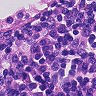

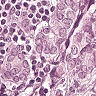

In [2]:
display(dataset[0][0])
display(dataset[1][0])

---
## 4. Computing dataset statistics

The following code blocks compute statistics about the dataset.

### 4.1 Images Sizes

In [5]:
# Instantiate the dataset and convert samples to tensors
import torch
from torchvision.transforms.v2 import Compose, ToImage, ToDtype, CenterCrop
PIL_to_tensor  = Compose([ToImage(), CenterCrop(42), ToDtype(torch.float32, scale=True)])
dataset = PCamDataset(data_dir="./data", transform=PIL_to_tensor)

# Compute images sizes statistics
img_stats = {}
for img, label in dataset:
    img_shape = tuple(img.shape)
    if not img_shape in img_stats: img_stats[img_shape] = 1
    else: img_stats[img_shape] += 1

l = [ (count, shape) for shape, count in img_stats.items() ]

In [6]:
# Display images sizes (shape) statistics sorted by count
total = len(dataset)
print("{0:>15s} | {1:5s} | {2:5s} %".format("Shape", "Count", "Percent."))
for c,s in sorted(l, reverse=True):
    print("{0:>15s} | {1:5d} | {2:5.2f} %".format(str(s), c, 100*c/total))

          Shape | Count | Percent. %
    (3, 42, 42) | 327680 | 100.00 %


As expected, the dataset is composed of 3-channel images of size 96 x 96px

### 4.2 Mean and Standard Deviation

In [7]:
compute_mean_stdev = True

In [8]:
import torch
import numpy as np

def compute_mean_std(img_dataset):
    # Compute the mean
    mean = 0.0
    count = 0
    for image, _ in img_dataset:
        flatten_img = torch.flatten(image, start_dim=1)
        mean  += flatten_img.sum(1)  # Sum all the pixes in each channel
        count += flatten_img.size(1) # Count the number of pixes per channel
    mean = mean / count
    # Compute the std
    std = 0.0
    for image, _ in img_dataset:
        flatten_img = torch.flatten(image, start_dim=1)
        flatten_img = flatten_img.permute(1,0) - mean
        flatten_img = torch.pow(flatten_img,2)
        std += flatten_img.sum(0)  # Sum all the pixes in each channel
    std = torch.pow(std / count, 0.5)
    return {"mean":mean, "std": std}

In [9]:
if compute_mean_stdev:
    from torchvision.transforms.v2 import Compose, ToImage, ToDtype, CenterCrop
    PIL_to_tensor  = Compose([ToImage(), CenterCrop(42), ToDtype(torch.float32, scale=True)])
    dataset = PCamDataset(data_dir="./data", transform=PIL_to_tensor)

    # Compute the mean and stdev statistics
    datasets_stats = compute_mean_std(dataset)
    print(datasets_stats)

{'mean': tensor([0.6982, 0.5344, 0.6907]), 'std': tensor([0.2343, 0.2761, 0.2113])}


---
## 5. Inspect dataset samples

The following code block display a grid with ransom samples from a dataset.

In [10]:
import matplotlib.pyplot as plt

def plot_samples(dataset, rows=5, cols=2, fig_scale_factor=3, class_names=None, denormalize=None, title=None):
    torch.manual_seed(42)
    rdn_indices = torch.randint(0, len(dataset), (rows*cols,))
    fig = plt.figure(figsize=(fig_scale_factor*cols, fig_scale_factor*rows))
    plt.axis(False)
    if title: 
        plt.title(title)
    for i in range(rows*cols):
        random_idx = rdn_indices[i].item()
        img, label = dataset[random_idx]
        img = img.permute(1,2,0)
        if denormalize:
            img = (img*denormalize["std"])+denormalize["mean"]
        ax = fig.add_subplot(rows, cols, i+1)
        if class_names:
            ax.set_title(f"{class_names[label]}")
        else:
            ax.set_title(f"{label}")
        plt.imshow(img)
    plt.tight_layout()
    plt.show()

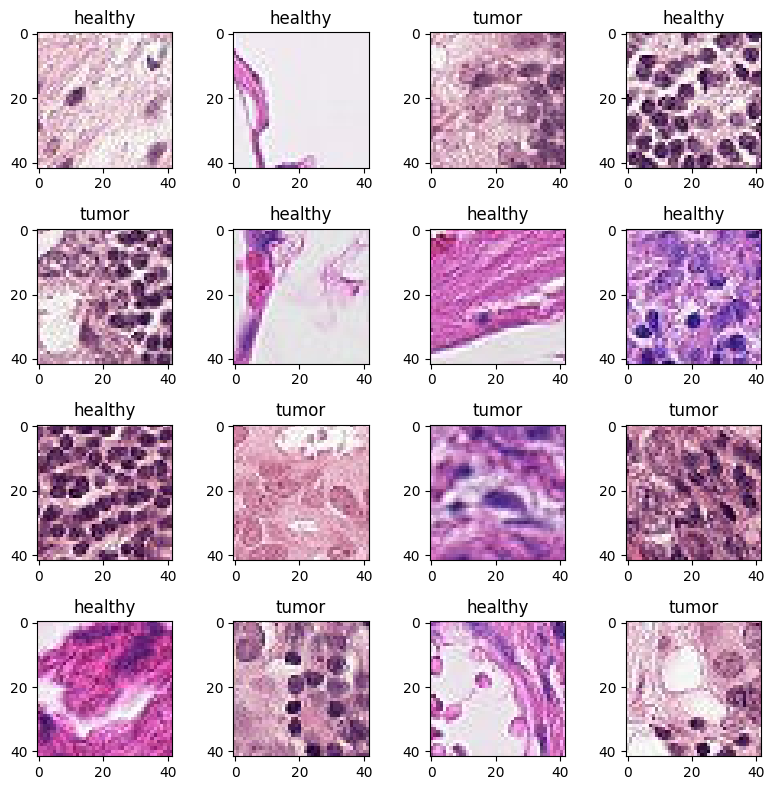

In [11]:
from torchvision.transforms.v2 import Compose, ToImage, ToDtype, Resize
PIL_to_tensor  = Compose([ToImage(), CenterCrop(42), ToDtype(torch.float32, scale=True)])
dataset = PCamDataset(data_dir="./data", transform=PIL_to_tensor)

plot_samples(dataset=dataset, class_names=dataset.classes, fig_scale_factor=2, rows=4, cols=4)

---
## 6. Instantiate and inspect data module

In this section we will instantiate the data module and inspect the data loader's statistics.

### 6.1 Instantiating the data module

In [12]:
from pcam_dataset import PCamDataModule

datamodule = PCamDataModule(data_dir="./data", batch_size=64)

print(datamodule)

TypeError: CenterCrop.__init__() takes 2 positional arguments but 3 were given

### 6.2 Check the # of batches and the shape of each partition's first batch

In [ ]:
from collections import deque

print("{0:10s} {1:<15s} {2:20s} {3:20s}".format("Set name", "# of batches", "first batch shape", "last batch shape"))
for s, sdl in [ ("train", datamodule.train_dataloader()), ("val", datamodule.val_dataloader()), ("test", datamodule.test_dataloader()) ]:
    batch = next(iter(sdl))
    last_batch = deque(iter(sdl), maxlen=1).pop()
    print("{0:10s} {1:<15d} {2:20s} {3:20s}".format(s, len(sdl), str(tuple(batch[0].shape)), str(tuple(last_batch[0].shape))))


Set name   # of batches    first batch shape    last batch shape    
train      4096            (64, 3, 128, 128)    (64, 3, 128, 128)   
val        512             (64, 3, 128, 128)    (64, 3, 128, 128)   
test       512             (64, 3, 128, 128)    (64, 3, 128, 128)   


---
## 7. Loading fewer training samples 

It is often useful to train machine learning models on a subset of the training data to evaluate performance under low-data regimes. 
This can help assess model robustness and generalization with limited supervision.

To support this scenario, the PCamDataModule includes flexible options:

* Fractional Sampling: Users can specify the fraction of the training dataset to use when retrieving the training dataloader.

*  Per-Class Sampling: Alternatively, users can define the number of samples per class to include, enabling balanced or controlled sampling across categories.

These features make it easier to simulate data-scarce settings and run experiments with varying data availability.

### 7.1 Check the # of batches and the shape of the training dataloader when configured to read only a fraction of the training data

In [ ]:
for fraction in [0.01, 0.1, 0.5, 1.0]:
    print(f"Setting up train data loader with {fraction*100} % of the training set")
    dl = datamodule.train_dataloader(fraction=fraction)
    batch = next(iter(dl))
    last_batch = deque(iter(sdl), maxlen=1).pop()
    print(f" - number of batches: {len(dl)}")
    print(f" - first batch shape: {tuple(batch[0].shape)}")
    print(f" - last batch shape : {tuple(last_batch[0].shape)}")

Setting up train data loader with 1.0 % of the training set
 - number of batches: 41
 - first batch shape: (64, 3, 128, 128)
 - last batch shape : (64, 3, 128, 128)
Setting up train data loader with 10.0 % of the training set
 - number of batches: 410
 - first batch shape: (64, 3, 128, 128)
 - last batch shape : (64, 3, 128, 128)
Setting up train data loader with 50.0 % of the training set
 - number of batches: 2048
 - first batch shape: (64, 3, 128, 128)
 - last batch shape : (64, 3, 128, 128)
Setting up train data loader with 100.0 % of the training set
 - number of batches: 4096
 - first batch shape: (64, 3, 128, 128)
 - last batch shape : (64, 3, 128, 128)


### 7.2 Check the # of batches and the shape of the training dataloader batches when configured to read only a given number of samples per class from the training data

In [ ]:
for samples_per_class in [1, 2, 4, 8, 16]:

    print(f"Setting up train data loader with {samples_per_class} sample(s) per class")
    dl = datamodule.train_dataloader(samples_per_class=samples_per_class)
    batch = next(iter(dl))
    last_batch = deque(iter(sdl), maxlen=1).pop()
    print(f" - number of batches: {len(dl)}")
    print(f" - first batch shape: {tuple(batch[0].shape)}")
    print(f" - last batch shape : {tuple(last_batch[0].shape)}")
    

Setting up train data loader with 1 sample(s) per class
 - number of batches: 1
 - first batch shape: (2, 3, 128, 128)
 - last batch shape : (64, 3, 128, 128)
Setting up train data loader with 2 sample(s) per class
 - number of batches: 1
 - first batch shape: (4, 3, 128, 128)
 - last batch shape : (64, 3, 128, 128)
Setting up train data loader with 4 sample(s) per class
 - number of batches: 1
 - first batch shape: (8, 3, 128, 128)
 - last batch shape : (64, 3, 128, 128)
Setting up train data loader with 8 sample(s) per class
 - number of batches: 1
 - first batch shape: (16, 3, 128, 128)
 - last batch shape : (64, 3, 128, 128)
Setting up train data loader with 16 sample(s) per class
 - number of batches: 1
 - first batch shape: (32, 3, 128, 128)
 - last batch shape : (64, 3, 128, 128)
